# Evaluating SETI detection performance with swept parameters
This notebook runs multiple instances of notebook "01_seti_end_to_end.ipynb", which does the following:
1) Inputs a single RAW file 
2) Runs Rawspec to generate a filterbank .h5 spectrogram file with specified fine FFT size and integration factor
3) Runs TurboSETI and/or seticore and compiles a list of detections and compute time (wall clock)

The primary sweep parameters are 
1) FFT size (which determines frequency resolution and equivalent noise bandwidth)
2) Short Term Integration (Pre-DeDoppler) spectrogram averaging parameter n_sti (aka int_factor or N_preDD)

This notebook is intended to work with special chirp test files created by 00_multichirp_raw_file_gen.ipynb (in seti_test_file_gen repository), 
which inserts a large number of chirp signals covering a wide range of drift rates. Parameters for GBT, MeerKAT, or COSMIC may be selected.
See https://github.com/khouston22/seti_test_file_gen.

Note that these sweeps can be done with various branches of seticore or seticore2 and detection SNR or timing comparisons
can be made between branches over multiple runs of this notebook.  For each run of this notebook, 
the desired seticore branch needs to be checked out and compiled, and 
the string "test_case" needs to be set in 01_seti_end_to_end.ipynb to indicate the branch.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import array
%matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

import src.plot_fns as pltg             # generic plot fns
import src.plot_h5_psd_sg1 as plt_h5    # blimpy-based plot fns

parameters_are_undefined = False

verbose = False
fb_ext = '.h5'

raw_dir = os.getenv('RAWDIR') + '/'
if not os.path.isdir(raw_dir[0:-1]):
    os.system('mkdir '+raw_dir[0:-1])

raw_backup_base_dir = os.getenv('RAW_BACKUP_BASE_DIR') + '/'

def file_name_mjd(raw_file_stem):
    # specific to guppi file naming conventions
    stem_parts = raw_file_stem.split('_')
    if (len(stem_parts)<4):
         mjd_int = 99999
    elif (stem_parts[1]=='guppi'):
        mjd_int = int(stem_parts[2])
    elif (stem_parts[2]=='guppi'):
        mjd_int = int(stem_parts[3])
    else:
        mjd_int = 99999
    #print(mjd_int)   
    return mjd_int


In [2]:
try:
    raw_files_are_undefined
except NameError:
    raw_files_are_undefined = True     
    print('Raw files are undefined, using defaults\n')

display_figs01 = False
display_figs02 = True
plot_dets1 = True
plot_dets2 = False
plot_sg_psd_zoom = False
plot_psd_zoom = False
plot_sg_zoom = False
plot_sg_wb = False
plot_psd_wb = False
zoom_bw_MHz = .012  # +/- 6 KHz
max_n_zoom_plots = 100

do_fig_text_only = True   # True normally, False to generate copy of figures without text for pubs
search_max_drift = 10.
search_min_drift = -10.

if raw_files_are_undefined:
    if (1):
        raw_backup_subdir = 'raw_multichirp/'
        raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec'  # seticore crashes n_sti=1
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec'
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec'
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec'
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec'
    elif (0):
        raw_backup_subdir = 'raw_multichirp/'
        raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec'
    elif (0):
        raw_backup_subdir = 'raw_multichirp/'
        raw_file_stem = 'meerkat-chirp80-0.0040V-1502.23-1502.77-m10.0-10.0-Hzsec-321.49sec'
        # raw_file_stem = 'meerkat-chirp80-0.0040V-1502.23-1502.77-m10.0-10.0-Hzsec-40.19sec'
    elif (0):
        raw_backup_subdir = 'raw_multichirp/'
        raw_file_stem = 'cosmic-chirp80-0.0040V-1401.70-1402.30-m10.0-10.0-Hzsec-67.11sec'
    elif (0):
        raw_backup_subdir = 'raw_multichirp/'
        raw_file_stem = 'cosmic-chirp80-0.0040V-1401.70-1402.30-m50.0-50.0-Hzsec-67.11sec'
        search_max_drift = 50
        search_min_drift = -50

                
print(f'{raw_file_stem = }')

delete_h5_sg_file = True        # =True h5 sg file will be deleted after finishing (reduce file space in $SGDIR)
delete_raw_file_enable = False  # Must be False for this notebook: will keep raw file in $RAWDIR regardless
enable_raw_backup_copy = True   # Must be True for this notebook: copy to $RAWDIR if needed from $RAW_BACKUP_BASE_DIR/raw_backup_subdir

run_turbo = False

if do_fig_text_only:
    n_fig_copies = 1
else:
    n_fig_copies = 2    # second copy created without text in plot area

drift_limit_nHz = 1.0  # assume 2 sigma limit
f_sigma_drift = np.array([1.5, 3, 6])*1e9
sigma_drift = drift_limit_nHz*f_sigma_drift/2.*1e-9
print(f'sigma_drift = {sigma_drift}')


Raw files are undefined, using defaults

raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec'
sigma_drift = [0.75 1.5  3.  ]


#### Run end-to-end test over parameter sweeps

In [3]:
isChirp = raw_file_stem.lower().find('chirp')>=0
isVoyager = raw_file_stem.lower().find('voyager')>=0
isguppi = raw_file_stem.lower().find('guppi')>=0

if isChirp:
    raw_parts_list = raw_file_stem.split('-')
    telescope = raw_parts_list[0]
    
    if (raw_file_stem.lower().find('gbt')>=0):    # GBT/Parkes HSR2A, but 512 avg rather than 51*16=816 avg (183 sec vs 292)
    
        fine_fft_size_list = np.array([1, 2, 4])*1024*512
        # n_sti_list = np.array([1, 2, 4, 8, 16, 32])
        n_sti_list = np.array([2, 4, 8, 16, 32, 64])
        select_params = [[1024*1024,32],[1024*1024,4],[1024*1024*2,2]]
        select_params2 =  [[1024*1024,32], [1024*1024, 8],[1024*1024, 4], [2048*1024, 2]]
        fig_dir = './chirp_gbt_plots/'

    elif(raw_file_stem.lower().find('meerkat')>=0):   # MeerKAT 1K mode
    
        fine_fft_size_list = np.array([1, 2, 4, 8])*1024*256
        n_sti_list = np.array([1, 2, 4, 8, 16])
        select_params = [[1024*512,8],[1024*512,2],[1024*512,1],[1024*1024,1]]
        select_params2 =  [[256*1024, 4],[512*1024, 2], [1024*1024, 1], [2048*1024, 1]]
        fig_dir = './chirp_mk_plots/'
    
    elif(raw_file_stem.lower().find('cosmic')>=0):  # COSMIC VLA
    
        fine_fft_size_list = np.array([1, 2, 4])*1024*256
        n_sti_list = np.array([1, 2, 4])
        select_params = [[1024*512,1],[1024*512,2],[1024*256,1]]
        select_params2 =  [[256*1024, 1], [512*1024, 1], [1024*1024, 1]]
        fig_dir = './chirp_cosmic_plots/'
    
else:
    print(f'Note: special chirp file expected, skipping execution\n')
    # stop, or return to calling notebook/script
    assert(False)

print(f'Figures will appear in in {fig_dir}')

os.system('touch seticore_text_all.out')    
os.system('rm seticore_text_all.out')

Figures will appear in in ./chirp_gbt_plots/


0

#### Copy raw file from external storage to local directory if not present
Required for assessment of rawspec processing time relative to search

In [4]:
raw_file_base_name = raw_dir + raw_file_stem + '.0000.raw'
raw_file_delete_spec = raw_dir + raw_file_stem + '.00*.raw'

print(raw_file_base_name)
if os.path.isfile(raw_file_base_name): 
    print('Raw file found in raw directory')
else:
    raw_file_backup_name = raw_backup_base_dir + raw_backup_subdir + raw_file_stem + '.0000.raw'
    raw_file_backup_spec = raw_backup_base_dir + raw_backup_subdir + raw_file_stem + '.00*.raw'
    if os.path.isfile(raw_file_backup_name): 
        print('Raw file found in backup directory, copying')
        if (1):     # single raw file .0000.raw
            print(raw_file_backup_name)
            os.system('cp '+raw_file_backup_name+' '+raw_dir)
            os.system('chmod 666 '+raw_dir+'*.raw')  # remove read-only spec from raw_dir
        else:       # multi raw file .00xx.raw
            os.system('ls '+raw_file_backup_spec)
            os.system('cp '+raw_file_backup_spec+' '+raw_dir)
            os.system('chmod 666 '+raw_dir+'*.raw')  # remove read-only spec from raw_dir
        os.system('ls -lsah '+raw_dir+'*.raw')
        print('Copy complete')
        delete_raw_file = True
    else:
        print('Raw file not found in backup directory, skip')
        print(raw_file_backup_name)
        # stop, or return to calling notebook/script
        assert(False)

/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw
Raw file found in raw directory


Determine duration of raw file and other parameters

In [5]:
fine_fft_size = fine_fft_size_list[0]
n_sti = 1
import src.get_raw_info as raw
p = raw.get_run_params(raw_file_stem,raw_dir,fine_fft_size,n_sti)
# copy p entries into local variables
%run -i "src/raw_info_script.py"

fft_avg_product = fine_fft_size*n_sti*n_lti


raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.535, f_max_MHz = 6010.254

t_obs = 366.504, n_antennas = 1, n_coarse_channels = 4, n_pols = 2, n_bits = 8, chan_bw = 2929687.500
fs_coarse = 2929687.500, fine_fft_size = 524288, n_sti = 1, n_lti = 2048.0, n_avg = 2048.0
t_coarse = 3.413e-07, t_fine = 0.179, t_res = 0.179
fs_coar

#### Run 01_seti_end_to_end.ipynb for range of fft sizes and sti averages

In [6]:

i_run = 0
n_fft_list = len(fine_fft_size_list)
len_n_sti_list = len(n_sti_list)
n_run = n_fft_list*len_n_sti_list


n_det_max = 2000
n_sigma_drift = len(sigma_drift)

import time
import numpy as np

time_rawspec = np.ones((n_fft_list,len_n_sti_list))*np.nan
time_search = np.ones((n_fft_list,len_n_sti_list))*np.nan
time_search_total = np.ones((n_fft_list,len_n_sti_list))*np.nan
time_run = np.ones((n_fft_list,len_n_sti_list))*np.nan

f_start_truth_all = np.ones((n_det_max,n_fft_list,len_n_sti_list))*np.nan
drift_rate_truth_all = np.ones((n_det_max,n_fft_list,len_n_sti_list))*np.nan
ref_snr_db_all = np.ones((n_det_max,n_fft_list,len_n_sti_list))*np.nan

n_det_all = np.ones((n_fft_list,len_n_sti_list))*np.nan
det_f_start_MHz_all = np.ones((n_det_max,n_fft_list,len_n_sti_list))*np.nan
det_drift_rate_all = np.ones((n_det_max,n_fft_list,len_n_sti_list))*np.nan
det_snr_db_all = np.ones((n_det_max,n_fft_list,len_n_sti_list))*np.nan

det_snr_db_wavg_all = np.ones((n_fft_list,len_n_sti_list,n_sigma_drift))*np.nan

h5_size_MB_all = np.zeros((n_fft_list,len_n_sti_list))

n_lti_list = np.ones((n_fft_list,len_n_sti_list))*np.nan
T_avg_list = np.ones((n_fft_list,len_n_sti_list))*np.nan

print('fine_fft_size_list=',fine_fft_size_list)
print('n_sti_list=',n_sti_list,'\n')

import os
# open directory for figures if necessary
if not os.path.isdir(fig_dir[0:-1]):
    os.system('mkdir '+fig_dir[0:-1])

for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
    for i_sti, n_sti in enumerate(n_sti_list):
        
        p = raw.get_run_params(raw_file_stem,raw_dir,fine_fft_size,n_sti)
        # copy p entries into local variables
        # %run -i "src/raw_info_script.py"
        n_lti = p['n_lti']
        n_avg = p['n_avg']

        i_run += 1
        print(f'\nRun {i_run} of {n_run}')
        print(f'{fine_fft_size=}, {n_sti=}, {n_lti=}\n')

        if (n_lti<=2):
            print(f'Note: {n_lti=}, skipping this case\n')
            n_lti_list[i_fft,i_sti] = -n_lti
            continue
        else:
            t_obs = p['t_obs']

        # run the 01_seti_end_to_end jupyter notebook for one (n_fft, n_sti, n_lti) case

        t_run_start = time.time()
    
        %run ./01_seti_end_to_end.ipynb
    
        os.system('cat seticore_text.out >> seticore_text_all.out')

        # Note times are per raw channel
        time_rawspec[i_fft,i_sti] = t_rawspec
        time_search[i_fft,i_sti] = t_search
        time_search_total[i_fft,i_sti] = t_rawspec + t_search
        time_run[i_fft,i_sti] = time.time() - t_run_start

        f_start_truth_all[0:n_chirp,i_fft,i_sti] = f_start_truth
        drift_rate_truth_all[0:n_chirp,i_fft,i_sti] = drift_rate_truth
        ref_snr_db_all[0:n_chirp,i_fft,i_sti] = ref_snr_db

        n_det1 = min(n_det_max,n_det)
        n_det_all[i_fft,i_sti] = n_det1
        
        det_f_start_MHz_all[0:n_det1,i_fft,i_sti] = det_f_start_MHz[0:n_det1]
        det_drift_rate_all[0:n_det1,i_fft,i_sti] = det_drift_rate[0:n_det1]
        det_snr_db_all[0:n_det1,i_fft,i_sti] = det_snr_db[0:n_det1]

        det_snr_db_wavg_all[i_fft,i_sti,0:n_sigma_drift] = det_snr_db_wavg

        h5_size_MB_all[i_fft,i_sti] = h5_size_MB
        n_lti_list[i_fft,i_sti] = n_lti
        T_avg_list[i_fft,i_sti] = t_obs
        

fine_fft_size_list= [ 524288 1048576 2097152]
n_sti_list= [ 2  4  8 16 32 64] 

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.535, f_max_MHz = 6010.254

t_obs = 366.504, n_antennas = 1, n_coarse_channels = 4, n_pols = 2, n_bits = 8, chan_bw = 2929687.500
fs_coarse = 2929687.500, fine_fft_size = 524288, n_sti = 2, n_lti = 10

dedoppler elapsed time: 10s



Seticore search: 9.61 sec 2.40 sec/coarse channel
[27.65 27.49 27.29]
E(SNR)    [27.65 27.49 27.29] dB
SETI end-to-end completed, 37.37 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 6s



Seticore search: 5.27 sec 1.32 sec/coarse channel
[27.69 27.51 27.3 ]
E(SNR)    [27.69 27.51 27.3 ] dB
SETI end-to-end completed, 26.11 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 3s



Seticore search: 3.10 sec 0.77 sec/coarse channel
[27.69 27.52 27.18]
E(SNR)    [27.69 27.52 27.18] dB
SETI end-to-end completed, 20.33 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 1s



Seticore search: 1.96 sec 0.49 sec/coarse channel
[27.68 27.39 26.6 ]
E(SNR)    [27.68 27.39 26.6 ] dB
SETI end-to-end completed, 19.24 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 1s



Seticore search: 1.30 sec 0.33 sec/coarse channel
[27.57 26.79 25.21]
E(SNR)    [27.57 26.79 25.21] dB
SETI end-to-end completed, 17.58 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 1s



Seticore search: 1.11 sec 0.28 sec/coarse channel
[26.89 25.3  23.11]
E(SNR)    [26.89 25.3  23.11] dB
SETI end-to-end completed, 17.17 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 10s



Seticore search: 11.05 sec 2.76 sec/coarse channel
[29.3  29.12 28.88]
E(SNR)    [29.3  29.12 28.88] dB
SETI end-to-end completed, 46.76 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998

dedoppler elapsed time: 6s



Seticore search: 6.06 sec 1.52 sec/coarse channel
[29.29 29.02 28.3 ]
E(SNR)    [29.29 29.02 28.3 ] dB
SETI end-to-end completed, 26.36 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 4s



Seticore search: 4.22 sec 1.06 sec/coarse channel
[29.18 28.38 26.9 ]
E(SNR)    [29.18 28.38 26.9 ] dB
SETI end-to-end completed, 22.87 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 2s



Seticore search: 2.24 sec 0.56 sec/coarse channel
[28.35 26.82 24.74]
E(SNR)    [28.35 26.82 24.74] dB
SETI end-to-end completed, 19.75 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 2s



Seticore search: 1.54 sec 0.38 sec/coarse channel
[26.69 24.51 22.12]
E(SNR)    [26.69 24.51 22.12] dB
SETI end-to-end completed, 18.26 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 1s



Seticore search: 1.22 sec 0.31 sec/coarse channel
[24.89 22.3  19.69]
E(SNR)    [24.89 22.3  19.69] dB
SETI end-to-end completed, 17.53 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 14s



Seticore search: 14.39 sec 3.60 sec/coarse channel
[30.58 29.92 28.84]
E(SNR)    [30.58 29.92 28.84] dB
SETI end-to-end completed, 47.54 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998

dedoppler elapsed time: 9s



Seticore search: 9.26 sec 2.31 sec/coarse channel
[29.85 28.45 26.81]
E(SNR)    [29.85 28.45 26.81] dB
SETI end-to-end completed, 30.46 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 5s



Seticore search: 5.59 sec 1.40 sec/coarse channel
[28.06 26.21 24.32]
E(SNR)    [28.06 26.21 24.32] dB
SETI end-to-end completed, 23.42 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 4s



Seticore search: 4.60 sec 1.15 sec/coarse channel
[25.62 23.49 21.51]
E(SNR)    [25.62 23.49 21.51] dB
SETI end-to-end completed, 21.97 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 3s



Seticore search: 3.44 sec 0.86 sec/coarse channel
[22.76 20.67 18.82]
E(SNR)    [22.76 20.67 18.82] dB
SETI end-to-end completed, 20.77 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw' found, n_blocks_incr=128, n_blocks=128
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0001.raw' not found, n_raw_files=1, Total blocks=128
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.0000.raw'
Raw file found
Raw File size =  16385 MB, n_raw_files = 1
expected_file_size = 16384.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.

dedoppler elapsed time: 3s



Seticore search: 2.55 sec 0.64 sec/coarse channel
[19.93 17.93 16.41]
E(SNR)    [19.93 17.93 16.41] dB
SETI end-to-end completed, 19.19 sec

h5 sg file deleted
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec.rawspec.0000.h5



In [7]:
if verbose: p

#### Store results in npz file for later recall

In [8]:
# Write the data to a np savez file
z_name = fig_dir + raw_file_stem + '-' + test_case + ".npz"
print('Writing results to file',z_name)
np.savez_compressed(z_name,p=p,test_case=test_case,fine_fft_size_list=fine_fft_size_list,
                    n_sti_list=n_sti_list,n_lti_list=n_lti_list,T_avg_list=T_avg_list,telescope=telescope,
                    samples_per_block=samples_per_block,search_max_drift=search_max_drift,
                    search_min_drift=search_min_drift,search_z_threshold=search_z_threshold,
                    select_params=select_params,select_params2=select_params2,
                    f_sigma_drift=f_sigma_drift,sigma_drift=sigma_drift,
                    run_turbo=run_turbo,run_seticore=run_seticore,search_app_name=search_app_name,
                    time_rawspec=time_rawspec,time_search=time_search,
                    time_search_total=time_search_total,time_run=time_run,
                    f_start_truth_all=f_start_truth_all,drift_rate_truth_all=drift_rate_truth_all,
                    ref_snr_db_all=ref_snr_db_all,n_det_all=n_det_all,
                    n_det1=n_det1,det_f_start_MHz_all=det_f_start_MHz_all,
                    det_drift_rate_all=det_drift_rate_all,det_snr_db_all=det_snr_db_all,
                    det_snr_db_wavg_all=det_snr_db_wavg_all,raw_size_MB=raw_size_MB,
                    h5_size_MB_all=h5_size_MB_all,n_coarse_channels=n_coarse_channels)

# copy text output into figure directory
out_name = fig_dir + raw_file_stem + '-' + test_case + ".out"
os.system('cp seticore_text_all.out ' + out_name)

Writing results to file ./chirp_gbt_plots/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-sc2.npz


0

In [9]:
# write results to csv file
text_file_name = fig_dir + '22-' + raw_file_stem + '-seticore-snr-time-'+test_case+'.txt'
f = open(text_file_name,'w')
f.write(raw_file_stem + f', {test_case}\n')
f.write(f' \t  \tSearch \t \tEst SNR dB\t \n')
f.write(f'FFTsize\tNsti \tSec')
for idx, sigma_drift1 in enumerate(sigma_drift):
    f_sigma_drift1 = f_sigma_drift[idx]  
    f.write(f' \t{f_sigma_drift[idx]*1e-9:.1f}GHz')
f.write(f'\n')
for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
    fine_fft_size_K = fine_fft_size/1024
    for i_sti, n_sti in enumerate(n_sti_list):
        f.write(f'{fine_fft_size_K:.0f}K')
        f.write(f'\t{n_sti}')
        f.write(f' \t{time_search_total[i_fft,i_sti]:.2f}')
        for idx, sigma_drift1 in enumerate(sigma_drift):
            f_sigma_drift1 = f_sigma_drift[idx]       
            f.write(f' \t{det_snr_db_wavg_all[i_fft,i_sti,idx]:.2f}')
        f.write(f'\n')
f.close()


#### Plot composite results: SNR vs Drift Rate

Note: test_case string is defined within 01_seti_end_to_end

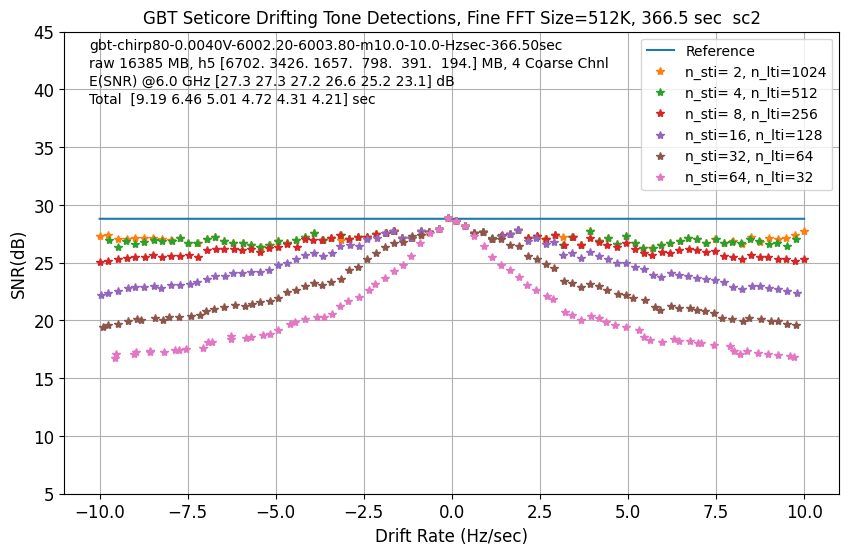

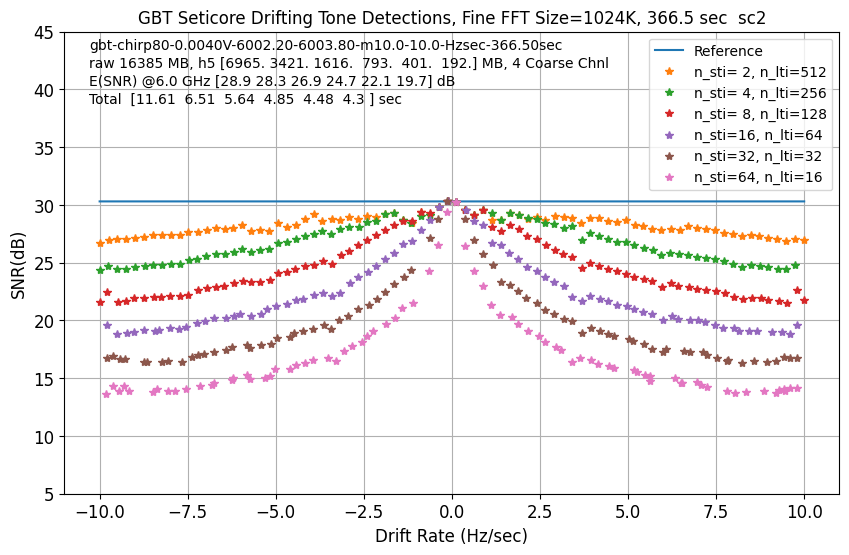

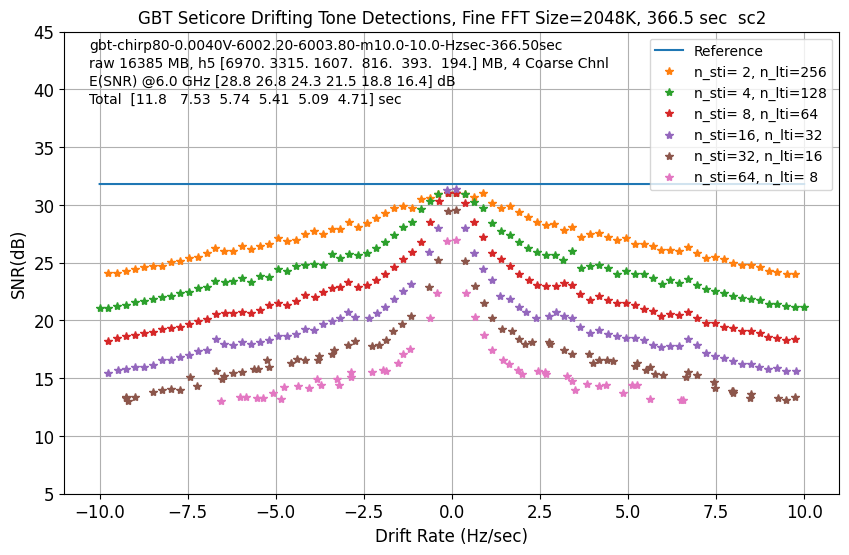

In [10]:
if isChirp:
    for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
            
        fine_fft_size_K = fine_fft_size/1024

        intf_legend = ['']*len(n_sti_list)
        for i_sti, n_sti in enumerate(n_sti_list):
            n_lti = n_lti_list[i_fft,i_sti]
            intf_legend[i_sti] = f'{n_sti=:2d}, {n_lti=:2.0f}'

        fig_text_list1=[[.15,.85,raw_file_stem],
                                [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
                                [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_db_wavg_all[i_fft,:,-1],precision=1) + ' dB'],
                                [.15,.76,f'Total  '+ np.array2string(time_search_total[i_fft,:],precision=2) + ' sec']]
    
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[drift_rate_truth_all[:,i_fft,0],det_drift_rate_all[:,i_fft,:]],
                y_data=[ref_snr_db_all[:,i_fft,0],det_snr_db_all[:,i_fft,:]],
                xy_markers = ['-','*'],
                xy_legend = ['Reference',intf_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[5., np.amax((45.,5.*np.ceil(ref_snr_db/5)+5.))],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + f' Seticore Drifting Tone Detections, Fine FFT Size={fine_fft_size_K:.0f}K, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '11-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'
        


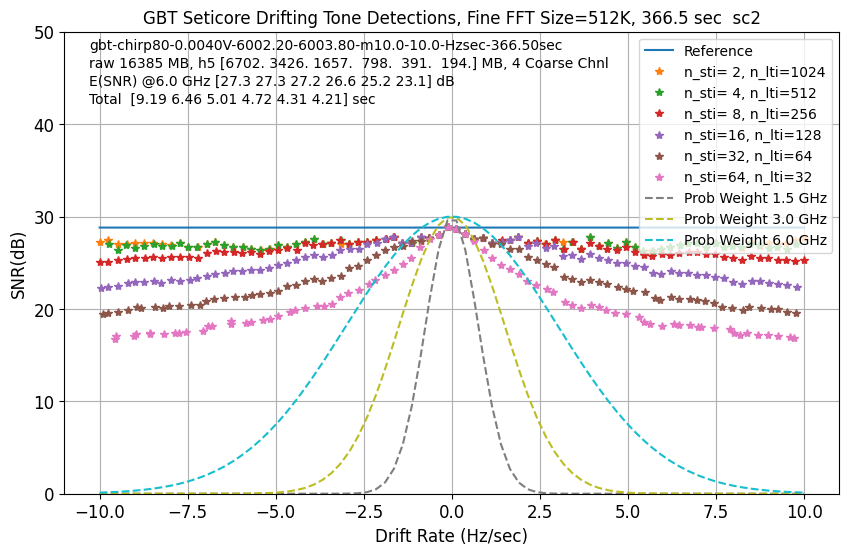

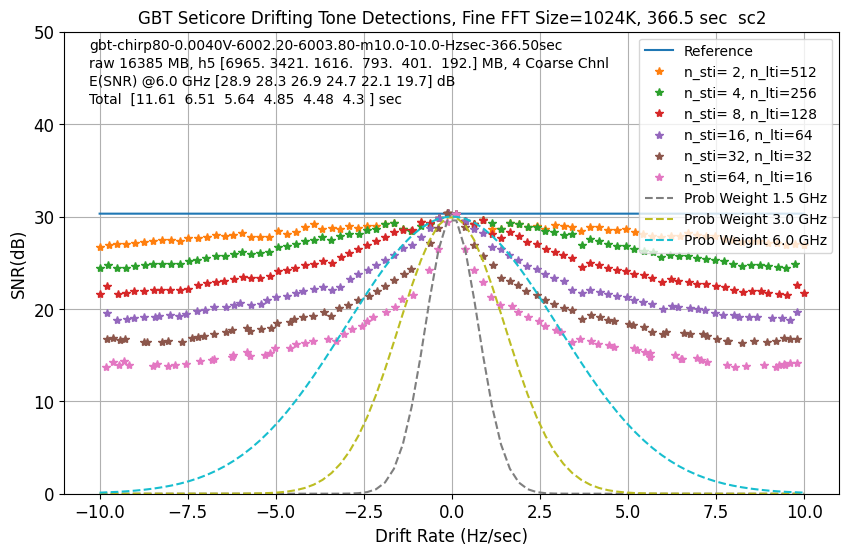

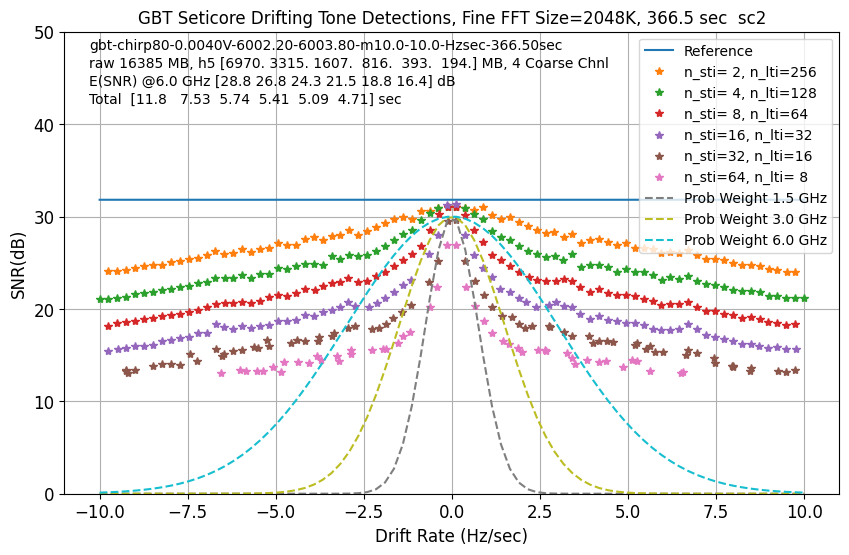

In [11]:
if isChirp:
    for i_fft, fine_fft_size in enumerate(fine_fft_size_list):
            
        fine_fft_size_K = fine_fft_size/1024

        intf_legend = ['']*len(n_sti_list)
        for i_sti, n_sti in enumerate(n_sti_list):
            n_lti = n_lti_list[i_fft,i_sti]
            intf_legend[i_sti] = f'{n_sti=:2d}, {n_lti=:2.0f}'

        drift_rate_truth = drift_rate_truth_all[:,i_fft,0]

        prob_weight = 30*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
        prob_legend = ['']*len(sigma_drift)
        for i_cfreq,cfreq in enumerate(f_sigma_drift):
                prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

        fig_text_list1=[[.15,.85,raw_file_stem],
            [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
            [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_db_wavg_all[i_fft,:,-1],precision=1) + ' dB'],
            [.15,.76,f'Total  '+ np.array2string(time_search_total[i_fft,:],precision=2) + ' sec']]

        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[drift_rate_truth,det_drift_rate_all[:,i_fft,:],drift_rate_truth],
                y_data=[ref_snr_db_all[:,i_fft,0],det_snr_db_all[:,i_fft,:],prob_weight],
                xy_markers = ['-','*','--'],
                xy_legend = ['Reference',intf_legend,prob_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., 50.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + f' {search_app_string} Drifting Tone Detections, Fine FFT Size={fine_fft_size_K:.0f}K, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '12-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'
         


#### Do plots for selected FFT and n_sti combinations

select_params =[[1048576, 32], [1048576, 4], [2097152, 2]]
fine_fft_size_list =array([ 524288, 1048576, 2097152])
n_sti_list =array([ 2,  4,  8, 16, 32, 64])


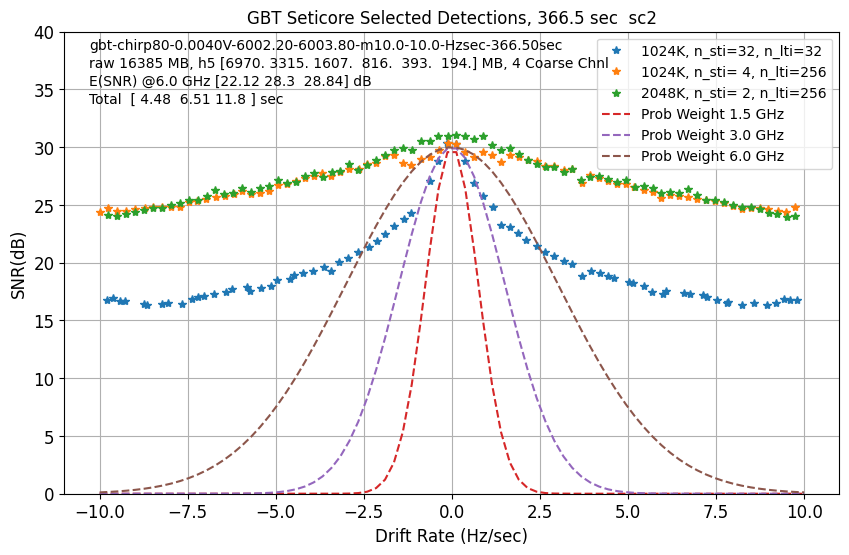

In [12]:
if isChirp:
    n_select = len(select_params)
    select_legend = ['']*n_select
    det_drift_rate_select = np.ones((n_det_max,n_select))*np.nan
    det_snr_db_select = np.ones((n_det_max,n_select))*np.nan
    h5_size_MB_select = np.ones((n_select))*np.nan
    time_search_total_select = np.ones((n_select))*np.nan
    det_snr_wavg_db_select = np.ones((n_select))*np.nan
    print(f'{select_params =}')
    print(f'{fine_fft_size_list =}')
    print(f'{n_sti_list =}')
    
    for i_select, s_params in enumerate(select_params):
            
        fine_fft_size = s_params[0]
        n_sti = s_params[1]

        fine_fft_size_K = fine_fft_size/1024
        
        i_fft  = np.where(fine_fft_size_list==fine_fft_size)[0][0]
        i_sti = np.where(n_sti_list==n_sti)[0][0]
        
        n_lti = n_lti_list[i_fft,i_sti]
        select_legend[i_select] = f'{fine_fft_size_K:.0f}K, {n_sti=:2.0f}, {n_lti=:2.0f}'

        try:
            det_drift_rate_select[:,i_select] = det_drift_rate_all[:,i_fft,i_sti]
            det_snr_db_select[:,i_select] = det_snr_db_all[:,i_fft,i_sti]
            h5_size_MB_select[i_select] = h5_size_MB_all[i_fft,i_sti]
            time_search_total_select[i_select] = time_search_total[i_fft,i_sti]
            det_snr_wavg_db_select[i_select] = det_snr_db_wavg_all[i_fft,i_sti,-1]
        except:
            print(f'Select parameters {s_params} out of range')

    prob_weight = 30*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
    prob_legend = ['']*len(sigma_drift)
    for i_cfreq,cfreq in enumerate(f_sigma_drift):
            prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

    fig_text_list1=[[.15,.85,raw_file_stem],
                [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
                [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_wavg_db_select,precision=2) + ' dB'],
                [.15,.76,f'Total  '+ np.array2string(time_search_total_select,precision=2) + ' sec']]

    ext_str = '.png'
    for i_plot in range(n_fig_copies):
        pltg.plot_generic(x_data=[det_drift_rate_select,drift_rate_truth],
            y_data=[det_snr_db_select,prob_weight],
            xy_markers = ['*','--'],
            xy_legend = [select_legend,prob_legend],
            x_limits=[sig_min_drift-1,sig_max_drift+1],
            y_limits=[0., 40.],
            x_label = 'Drift Rate (Hz/sec)',
            y_label = 'SNR(dB)',
            fig_title= telescope.upper() + f' {search_app_string} Selected Detections, {t_obs:.1f} sec  '+test_case,
            fig_text_list=fig_text_list1,
            legend_loc = 'upper right',
            display_fig=display_figs02,
            savfig_name=fig_dir + '14-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case+ext_str)
        fig_text_list1 = [] # do copy of plot without text in figure plot area
        ext_str = 'nt.png'
        
    


#### Do additional plots for selected FFT and n_sti combinations

select_params =[[1048576, 32], [1048576, 4], [2097152, 2]]
fine_fft_size_list =array([ 524288, 1048576, 2097152])
n_sti_list =array([ 2,  4,  8, 16, 32, 64])


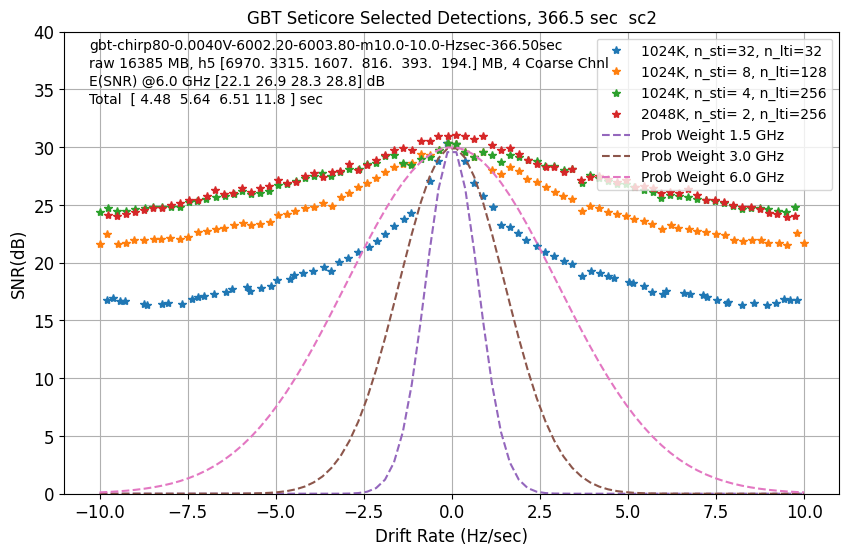

In [13]:
if isChirp:
    try:
        n_select = len(select_params2)
    except:
        n_select = 0
    if (n_select>0):
        select_legend = ['']*n_select
        det_drift_rate_select = np.ones((n_det_max,n_select))*np.nan
        det_snr_db_select = np.ones((n_det_max,n_select))*np.nan
        h5_size_MB_select = np.ones((n_select))*np.nan
        time_search_total_select = np.ones((n_select))*np.nan
        det_snr_wavg_db_select = np.ones((n_select))*np.nan
        print(f'{select_params =}')
        print(f'{fine_fft_size_list =}')
        print(f'{n_sti_list =}')
        
        for i_select, s_params in enumerate(select_params2):
                
            fine_fft_size = s_params[0]
            n_sti = s_params[1]

            fine_fft_size_K = fine_fft_size/1024
            
            i_fft  = np.where(fine_fft_size_list==fine_fft_size)[0][0]
            i_sti = np.where(n_sti_list==n_sti)[0][0]
            
            n_lti = n_lti_list[i_fft,i_sti]
            select_legend[i_select] = f'{fine_fft_size_K:.0f}K, {n_sti=:2.0f}, {n_lti=:2.0f}'

            try:
                det_drift_rate_select[:,i_select] = det_drift_rate_all[:,i_fft,i_sti]
                det_snr_db_select[:,i_select] = det_snr_db_all[:,i_fft,i_sti]
                h5_size_MB_select[i_select] = h5_size_MB_all[i_fft,i_sti]
                time_search_total_select[i_select] = time_search_total[i_fft,i_sti]
                det_snr_wavg_db_select[i_select] = det_snr_db_wavg_all[i_fft,i_sti,-1]
            except:
                print(f'Select parameters {s_params} out of range')

        prob_weight = 30*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
        prob_legend = ['']*len(sigma_drift)
        for i_cfreq,cfreq in enumerate(f_sigma_drift):
            prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

        fig_text_list1=[[.15,.85,raw_file_stem],
                        [.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[i_fft,:],precision=0)+ f' MB, {n_coarse_channels} Coarse Chnl'],
                        [.15,.79,f'E(SNR) @{f_sigma_drift[-1]*1e-9:.1f} GHz '+ np.array2string(det_snr_wavg_db_select,precision=1) + ' dB'],
                        [.15,.76,f'Total  '+ np.array2string(time_search_total_select,precision=2) + ' sec']]
    
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            pltg.plot_generic(x_data=[det_drift_rate_select,drift_rate_truth],
                y_data=[det_snr_db_select,prob_weight],
                xy_markers = ['*','--'],
                xy_legend = [select_legend,prob_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., 40.],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + f' {search_app_string} Selected Detections, {t_obs:.1f} sec  '+test_case,
                fig_text_list=fig_text_list1,
                legend_loc = 'upper right',
                display_fig=display_figs02,
                savfig_name=fig_dir + '15-' + raw_file_stem + f'-FineFFT-{fine_fft_size_K:.0f}K' + '-seticore-det-'+test_case+ext_str)
            fig_text_list1 = [] # do copy of plot without text in figure plot area
            ext_str = 'nt.png'

#### Plot composite SNR vs compute time curves

sigma_drift = [0.75 1.5  3.  ]
./chirp_gbt_plots/21-gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-fctr-2GHz-seticore-snr-time-sc2.png


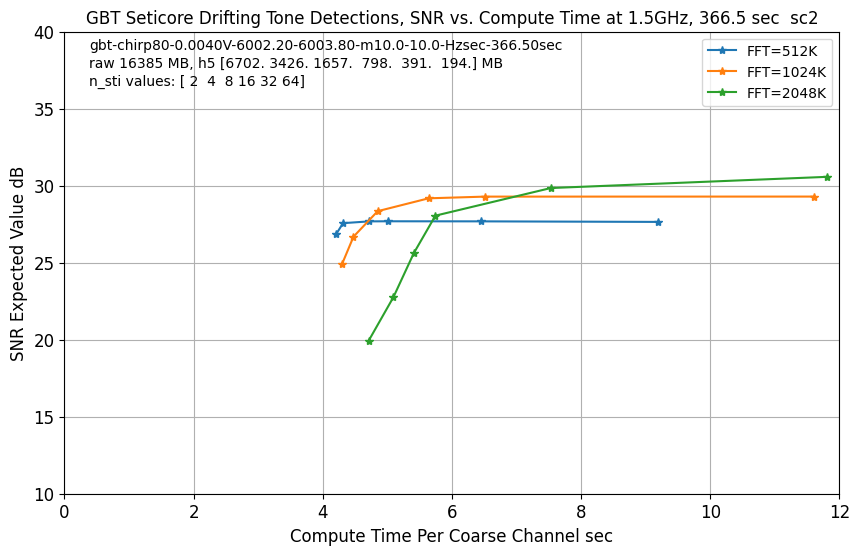

./chirp_gbt_plots/21-gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-fctr-3GHz-seticore-snr-time-sc2.png


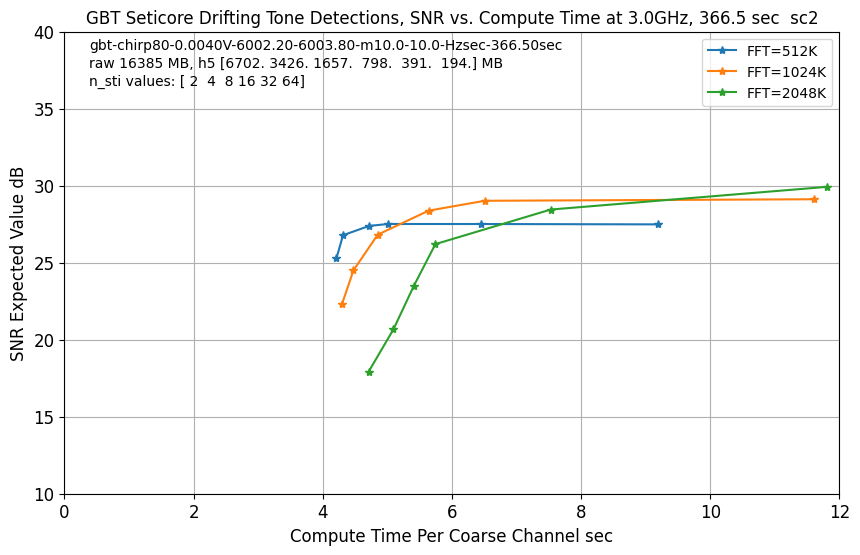

./chirp_gbt_plots/21-gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-fctr-6GHz-seticore-snr-time-sc2.png


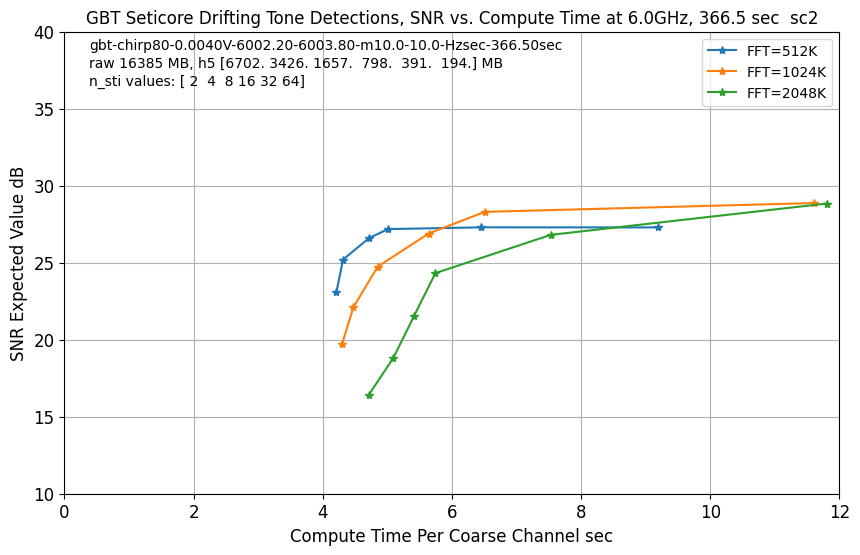

In [14]:
print(f'sigma_drift = {sigma_drift}')

if isChirp:
    %matplotlib inline
    wavg_max = np.nanmax(det_snr_db_wavg_all)
    wavg_min = np.nanmin(det_snr_db_wavg_all)
    
    # idx = 1     # just choose 3 GHz
    # sigma_drift1 = sigma_drift[idx]
    # if (True):
    for idx, sigma_drift1 in enumerate(sigma_drift):

        f_sigma_drift1 = f_sigma_drift[idx]       
        fine_fft_size_list_K = fine_fft_size_list/1024
    
        ext_str = '.png'
        for i_plot in range(n_fig_copies):
            
            fig = plt.figure(figsize=(10, 6))
            
            for i_fft, fine_fft_size_K in enumerate(fine_fft_size_list_K):
                plt.plot(time_search_total[i_fft,:],det_snr_db_wavg_all[i_fft,:,idx],'-*',label=f'FFT={fine_fft_size_K:.0f}K')
            
            # plt.xlim(0.,4.*np.ceil(np.nanmax(time_search_total[i_fft,:]/4.)))
            # plt.xlim(2.*np.floor(np.nanmin(time_search_total[0,:]/2.)),2.*np.ceil(np.nanmax(time_search_total[i_fft,:]/2.)))
            xlim_max = 2.*np.ceil(np.nanmax(time_search_total[:]/2.))
            if (xlim_max<10.): xlim_max=10.;
            plt.xlim(0.,xlim_max)
        
            plt.title(f'{telescope.upper()} {search_app_string} Drifting Tone Detections, SNR vs. Compute Time at {f_sigma_drift1*1e-9:.1f}GHz, {t_obs:.1f} sec  '+test_case )

            # plt.ylim(5*(np.floor((wavg_min-2)/5)),5*(np.ceil(wavg_max/5)+1))
            plt.ylim(10.,40.)
            plt.xlabel('Compute Time Per Coarse Channel sec')
            plt.ylabel('SNR Expected Value dB')
            if i_plot==0:
                plt.figtext(.15,.85,raw_file_stem)
                plt.figtext(.15,.82,f'raw {raw_size_MB:3.0f} MB, h5 '+np.array2string(h5_size_MB_all[0,:],precision=0)+ ' MB')
                plt.figtext(.15,.79,f'n_sti values: '+ np.array2string(n_sti_list,precision=0))
            plt.legend(loc='upper right')
            plt.grid()

            fig_name = fig_dir + '21-' + raw_file_stem + f'-fctr-{f_sigma_drift1*1e-9:.0f}GHz' + '-seticore-snr-time-'+test_case+ext_str
                        
            print(fig_name)
            plt.savefig(fig_name,bbox_inches='tight')

            if display_figs02:
                plt.show()
            else:
                plt.close(fig)
                
            ext_str = 'nt.png' # for second pass, do copy of plot without text in figure plot area
        

In [15]:
print('Done')

# Beep in WSL
os.system("powershell.exe '[console]::beep(261.6,700)'")
os.system("powershell.exe '[console]::beep(261.6,700)'")



Done


0